In [6]:
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_ibm_runtime.fake_provider import FakeAlmadenV2
from qiskit import QuantumCircuit, transpile
from qiskit.providers.fake_provider import GenericBackendV2


import numpy as np
import pandas as pd

import networkx as nx
from networkx.algorithms import bipartite

import matplotlib.pyplot as plt

import random

from pyomo.environ import ConcreteModel, Var, Objective, Constraint, SolverFactory, Binary, maximize
from scipy.optimize import minimize
from itertools import combinations

import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit.visualization import *
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit.primitives import Estimator
from qiskit.primitives import Sampler, BackendSampler, BackendSamplerV2

from qiskit_algorithms import QAOA
from qiskit_algorithms.optimizers import COBYLA
from qiskit.primitives import Estimator
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.circuit.library import QAOAAnsatz

from qiskit.circuit.library import EfficientSU2


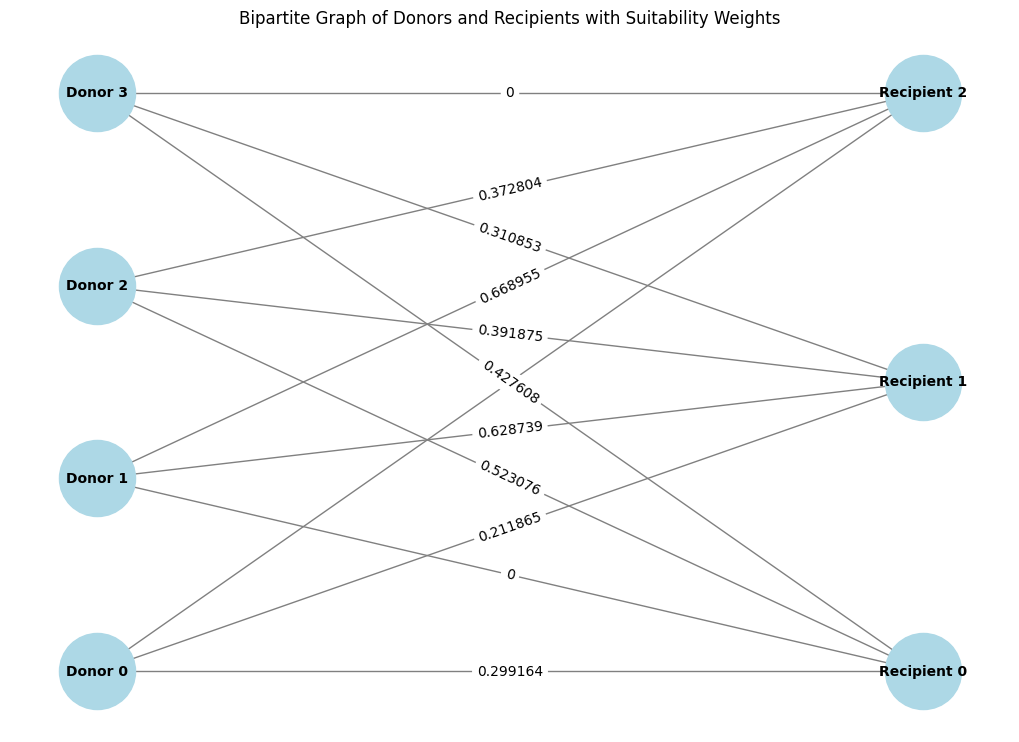

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
from qiskit_optimization import QuadraticProgram

# Define the problem
n_donors = 4  # Number of donors
n_recipients = 3  # Number of recipients
weights = [
    [0.299164, 0.211865, 0],  # Donor 0
    [0, 0.628739, 0.668955],   # Donor 1
    [0.523076, 0.391875, 0.372804],  # Donor 2
    [0.427608, 0.310853, 0]   # Donor 4
]  # Example weights

# Initialize QUBO
qubo = QuadraticProgram()

for i in range(n_donors):
    for j in range(n_recipients):
        qubo.binary_var(name=f"x_{i}_{j}")

objective_terms = []
for i in range(n_donors):
    for j in range(n_recipients):
        objective_terms.append(weights[i][j])

qubo.maximize(linear={f"x_{i}_{j}": weights[i][j] for i in range(n_donors) for j in range(n_recipients)})

G = nx.Graph()

donor_nodes = [f"Donor {i}" for i in range(n_donors)]
recipient_nodes = [f"Recipient {j}" for j in range(n_recipients)]
G.add_nodes_from(donor_nodes, bipartite=0)
G.add_nodes_from(recipient_nodes, bipartite=1)

for i in range(n_donors):
    for j in range(n_recipients):
        G.add_edge(donor_nodes[i], recipient_nodes[j], weight=weights[i][j])

# Draw the bipartite graph
pos = nx.bipartite_layout(G, nodes=donor_nodes)
plt.figure(figsize=(10, 7))
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=10, font_weight='bold', edge_color='gray')
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title("Bipartite Graph of Donors and Recipients with Suitability Weights")
plt.show()


In [3]:
# Add constraints for donors (each donor must match with one recipient)
for i in range(n_donors):
    qubo.linear_constraint(linear={f"x_{i}_{j}": 1 for j in range(n_recipients)}, sense='<=', rhs=1, name=f"donor_{i}")

# Add constraints for recipients (each recipient must match with one donor)
for j in range(n_recipients):
    qubo.linear_constraint(linear={f"x_{i}_{j}": 1 for i in range(n_donors)}, sense='==', rhs=1, name=f"recipient_{j}")


In [4]:
print(qubo.prettyprint())

Problem name: 

Maximize
  0.299164*x_0_0 + 0.211865*x_0_1 + 0.628739*x_1_1 + 0.668955*x_1_2
  + 0.523076*x_2_0 + 0.391875*x_2_1 + 0.372804*x_2_2 + 0.427608*x_3_0
  + 0.310853*x_3_1

Subject to
  Linear constraints (7)
    x_0_0 + x_0_1 + x_0_2 <= 1  'donor_0'
    x_1_0 + x_1_1 + x_1_2 <= 1  'donor_1'
    x_2_0 + x_2_1 + x_2_2 <= 1  'donor_2'
    x_3_0 + x_3_1 + x_3_2 <= 1  'donor_3'
    x_0_0 + x_1_0 + x_2_0 + x_3_0 == 1  'recipient_0'
    x_0_1 + x_1_1 + x_2_1 + x_3_1 == 1  'recipient_1'
    x_0_2 + x_1_2 + x_2_2 + x_3_2 == 1  'recipient_2'

  Binary variables (12)
    x_0_0 x_0_1 x_0_2 x_1_0 x_1_1 x_1_2 x_2_0 x_2_1 x_2_2 x_3_0 x_3_1 x_3_2



In [7]:
backend = GenericBackendV2(num_qubits=12)

In [9]:
qubo_to_qubo = QuadraticProgramToQubo()

qubo_model = qubo_to_qubo.convert(qubo)

In [10]:
op, offset = qubo_model.to_ising()
print("offset: {}".format(offset))
print("operator:")
print(op)

offset: 389.7125894999999
operator:
SparsePauliOp(['IIIIIIIIIIIZ', 'IIIIIIIIIIZI', 'IIIIIIIZIIII', 'IIIIIIZIIIII', 'IIIIIZIIIIII', 'IIIIZIIIIIII', 'IIIZIIIIIIII', 'IIZIIIIIIIII', 'IZIIIIIIIIII', 'IIIIIIIIZIII', 'IIIIIIIIIZII', 'ZIIIIIIIIIII', 'IIIIIIIIIIZZ', 'IIIIIIIIIZIZ', 'IIIIIIIIZIIZ', 'IIIIIZIIIIIZ', 'IIZIIIIIIIIZ', 'IIIIIIIIIZZI', 'IIIIIIIZIIZI', 'IIIIZIIIIIZI', 'IZIIIIIIIIZI', 'IIIIIIZIIZII', 'IIIZIIIIIZII', 'ZIIIIIIIIZII', 'IIIIIIIZZIII', 'IIIIIIZIZIII', 'IIIIIZIIZIII', 'IIZIIIIIZIII', 'IIIIIIZZIIII', 'IIIIZIIZIIII', 'IZIIIIIZIIII', 'IIIZIIZIIIII', 'ZIIIIIZIIIII', 'IIIIZZIIIIII', 'IIIZIZIIIIII', 'IIZIIZIIIIII', 'IIIZZIIIIIII', 'IZIIZIIIIIII', 'ZIIZIIIIIIII', 'IZZIIIIIIIII', 'ZIZIIIIIIIII', 'ZZIIIIIIIIII'],
              coeffs=[-65.1220945 +0.j, -65.165744  +0.j, -64.957307  +0.j, -64.937199  +0.j,
 -65.0101385 +0.j, -65.075739  +0.j, -65.0852745 +0.j, -65.0578725 +0.j,
 -65.11625   +0.j, -65.2716765 +0.j, -65.2716765 +0.j, -65.2716765 +0.j,
   1.20873475+0.j,   1.20873475+0.j,

In [11]:
circuit = QAOAAnsatz(reps=4, cost_operator=op)
circuit.measure_all()

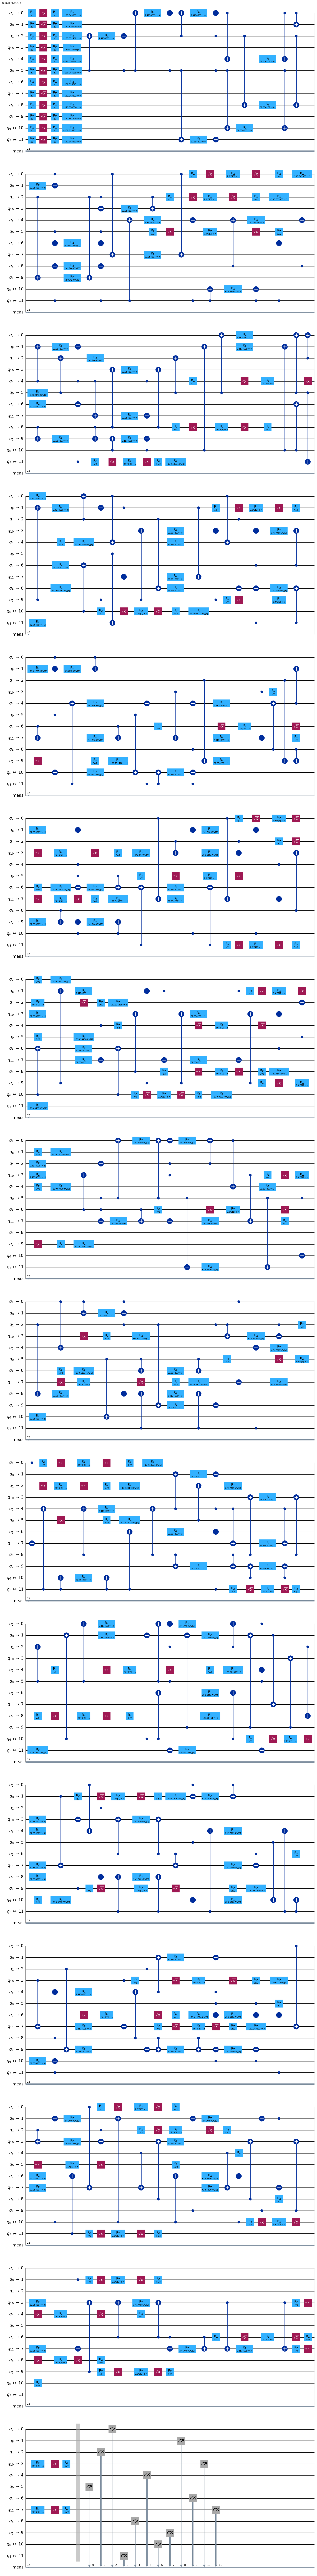

In [29]:
transpiled_circuit = transpile(circuit, backend, optimization_level=3)
transpiled_circuit.draw('mpl')

In [36]:
transpiled_circuit.assign_parameters()
job = backend.run(transpiled_circuit)
print(job.status())

ValueError: Mismatching number of values and parameters. For partial binding please pass a dictionary of {parameter: value} pairs.

In [32]:
print(job.result().get_counts())

AerError: 'circuits have parameters but parameter_binds is not specified.'